In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import pickle
from overundersample import *
from sklearn.externals import joblib

def oheDecode(data):
    data2 = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        tmp = np.where((data[i,:]) == np.max(data[i,:]))
        try:
            data2[i] = tmp[0][0]
        except:
            print(data[i,:], tmp[0])
            quit()
    return data2

retrain = True

In [43]:
lf = '3'
with open('nnsets_us101_lf' + lf + '.pkl', 'rb') as f:
    (trainX, trainY, testX, testY, trainXLSTM, testXLSTM, locXYTrain, locXYTest, locXYpredtrain, locXYpredtest, features) = pickle.load(f)

In [44]:
testY = oheDecode(testY)

trainCfMat = confusion_matrix(oheDecode(trainY), oheDecode(trainY))
testCfMat = confusion_matrix(testY, testY)
cw = {i: sum(trainCfMat[j,j] for j in range(trainCfMat.shape[0]))/trainCfMat.shape[0]/trainCfMat[i,i] for i in range(trainCfMat.shape[0])}

In [95]:
bootstrap = 5*np.min(np.diag(trainCfMat))
undersample = False

trainCfMatBS = trainCfMat
print("training set:", np.diag(trainCfMat), "\nfreq:", np.diag(trainCfMat)/sum(np.diag(trainCfMat)))
print("test set:", np.diag(testCfMat), "\nfreq:", np.diag(testCfMat)/sum(np.diag(testCfMat)))
print("classes weights:", cw)

if bootstrap > 0:
    (trainXbs, _, trainYbs) = oversampleSet(trainX, np.zeros((1,1,1)), trainY, bootstrap, 0.1)
    trainCfMatBS = confusion_matrix(oheDecode(trainYbs), oheDecode(trainYbs))
    trainCfMat = trainCfMatBS
    print("training set after bootstrap:", np.diag(trainCfMatBS), "\nfreq:", np.diag(trainCfMatBS)/sum(np.diag(trainCfMatBS)))
else:
    trainXbs = trainX
    trainYbs = trainY

if undersample:
    (trainXbs, _, trainYbs) = undersampleSet(trainXbs, np.zeros((1,1,1)), trainYbs)
    trainCfMatBS = confusion_matrix(oheDecode(trainYbs), oheDecode(trainYbs))
    print("training set after undersampling:", np.diag(trainCfMatBS), "\nfreq:", np.diag(trainCfMatBS)/sum(np.diag(trainCfMatBS)))

training set: [66725 66725 66725 66725 66725] 
freq: [ 0.2  0.2  0.2  0.2  0.2]
test set: [53606  7228 14695   710  1802] 
freq: [ 0.68689535  0.09261798  0.18829846  0.00909778  0.02309043]
classes weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}
training set after bootstrap: [333625 333625 333625 333625 333625] 
freq: [ 0.2  0.2  0.2  0.2  0.2]


In [96]:
reorder = (np.array([i for i in range(trainYbs.shape[0])]))
np.random.shuffle(reorder)
trainXbs = trainXbs[reorder,:]
trainYbs = trainYbs[reorder,:]

In [97]:
trainCfMat = trainCfMatBS
cw = {i: np.sum(np.diag(trainCfMat))/trainCfMat.shape[0]/trainCfMat[i,i] for i in range(trainCfMat.shape[0])}

trainYdecode = oheDecode(trainYbs)

In [90]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=20, random_state=0, max_depth=25)
#clf = AdaBoostClassifier(n_estimators=250, random_state=0)
clf.fit(trainXbs, trainYdecode, sample_weight=np.array([cw[i] for i in trainYdecode]))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [91]:
print("Score train:", clf.score(trainXbs, trainYdecode), "test:", clf.score(testX,testY))#, "testi80:", clf.score(testXi80,testYi80))

predTrain = clf.predict(trainX)
predTrainbs = clf.predict(trainXbs)
predTest = clf.predict(testX)
# predTesti80 = clf.predict(testXi80)

print("Confusion matrices:")
print("Train\n",confusion_matrix(oheDecode(trainY), predTrain))
print("Train\n",confusion_matrix(trainYdecode, predTrainbs))
print("Test\n",confusion_matrix(testY, predTest))

Score train: 0.983562382915 test: 0.812342230366
Confusion matrices:
Train
 [[178192   8980  13366    170   1172]
 [  1057  25825      1     10      1]
 [   881      0  55096      0      2]
 [   154      0      0   2515      0]
 [   252      0      0      0   5801]]
Train
 [[63674   882  2119    22    28]
 [ 1057 65605     1    58     4]
 [  881     1 65818     2    23]
 [  154     0     0 66571     0]
 [  252     0     0     0 66473]]
Test
 [[46031  2847  4225    55   448]
 [ 2591  4471    49    66    51]
 [ 2387     6 12134    13   155]
 [  486    30    65   124     5]
 [  761    69   336     0   636]]


In [92]:
cfm = confusion_matrix(oheDecode(trainY), predTrain)
print("Training set")
print(cfm)
for i in range(cfm.shape[0]):
    print("p", cfm[i,i]/sum(cfm[k,i] for k in range(cfm.shape[0])),"r", cfm[i,i]/sum(cfm[i,k] for k in range(cfm.shape[0])))

Training set
[[178192   8980  13366    170   1172]
 [  1057  25825      1     10      1]
 [   881      0  55096      0      2]
 [   154      0      0   2515      0]
 [   252      0      0      0   5801]]
p 0.987016439934 r 0.8826629681
p 0.741991093234 r 0.96025135718
p 0.804755853527 r 0.984226227693
p 0.933209647495 r 0.942300487074
p 0.831565366972 r 0.958367751528


In [93]:
cfm = confusion_matrix((trainYdecode), predTrainbs)
print("Training set with bootstrap")
print(cfm)
for i in range(cfm.shape[0]):
    print("p", cfm[i,i]/sum(cfm[k,i] for k in range(cfm.shape[0])),"r", cfm[i,i]/sum(cfm[i,k] for k in range(cfm.shape[0])))

Training set with bootstrap
[[63674   882  2119    22    28]
 [ 1057 65605     1    58     4]
 [  881     1 65818     2    23]
 [  154     0     0 66571     0]
 [  252     0     0     0 66473]]
p 0.964494531794 r 0.954275009367
p 0.986719408013 r 0.983214687149
p 0.968795077865 r 0.986406893968
p 0.998769747798 r 0.997692019483
p 0.999173280423 r 0.996223304608


In [94]:
cfm = confusion_matrix(testY, predTest)
print("Test set")
print(cfm)
for i in range(cfm.shape[0]):
    print("p", cfm[i,i]/sum(cfm[k,i] for k in range(cfm.shape[0])),"r", cfm[i,i]/sum(cfm[i,k] for k in range(cfm.shape[0])))

Test set
[[46031  2847  4225    55   448]
 [ 2591  4471    49    66    51]
 [ 2387     6 12134    13   155]
 [  486    30    65   124     5]
 [  761    69   336     0   636]]
p 0.880874923454 r 0.858691191285
p 0.602317122457 r 0.618566685113
p 0.721875185912 r 0.825723035046
p 0.480620155039 r 0.174647887324
p 0.49111969112 r 0.352941176471


In [53]:
with open('rf_us101_lf' + lf + '.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [56]:
wrong_rf = np.where(predTest != (testY))
prob_rf = clf.predict_proba(testX)

ref 4.0
rf [ 0.82799899  0.00882295  0.01059003  0.00164078  0.15094724]


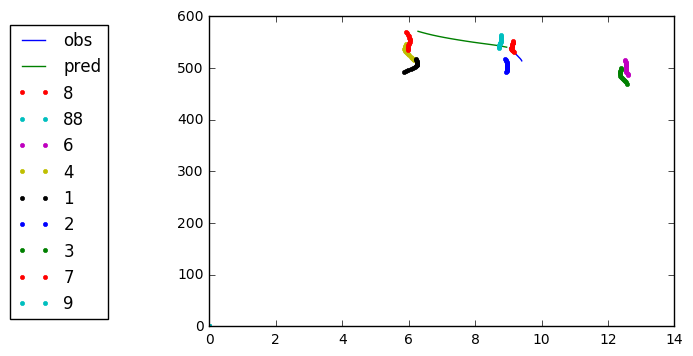

In [86]:
id = 51
numrecord = wrong_rf[0][id]
lbl = ['8','88','6','4','1','2','3','7','9']
v = [i for i in range(9)]
ySCols = [27+i for i in range(9)]
xSCols = [36+i for i in range(9)]
ttcCols = [18+i for i in range(9)]
plt.plot(locXYTest[numrecord,:,0]*10, locXYTest[numrecord,:,1]*10,label='obs')
plt.plot(locXYpredtest[numrecord,:,0]*10, locXYpredtest[numrecord,:,1]*10,label='pred')
for i in range(9):
    plt.plot(10*(testXLSTM[numrecord,:,xSCols[i]]+locXYTest[numrecord,:,0]),10*(testXLSTM[numrecord,:,ySCols[i]]+locXYTest[numrecord,:,1]),'.',label=lbl[i])
#plt.axis('equal')
#print(testXLSTM[numrecord,:,xSCols[8]]-testXLSTM[numrecord,:,xSCols[7]])
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', ncol=1)
#plt.axis('equal')
print("ref",testY[numrecord])
#print("boost",predY_boost[numrecord])
print("rf", prob_rf[numrecord,:])
plt.show()

In [27]:
testY.shape

(108882, 5)